In [2]:
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
from read_hdf5_func import von_neumann_entropy_sv
import h5py
import numpy as np
import os

# Read the HDF5 file
# filename = '/scratch/ty296/CT_toy/sv_comparison_L12_pctrl0.000_p0.400-0.600/final_results_L12.h5'
filename = 'p_ctrl0.4_46643361_worker0_hal0024.amarel.rutgers.edu_12566_L16.h5'
full_path = os.path.join('/scratch/ty296/hdf5_data/p_ctrl0.4', filename)

In [3]:
h5_file = h5py.File(full_path, 'r')
print(h5_file['metadata'].keys())

<KeysViewHDF5 ['result_1', 'result_10', 'result_11', 'result_12', 'result_13', 'result_14', 'result_15', 'result_16', 'result_17', 'result_18', 'result_19', 'result_2', 'result_20', 'result_3', 'result_4', 'result_5', 'result_6', 'result_7', 'result_8', 'result_9']>


In [4]:
# Explore what's inside result_11
print("Keys inside result_11:")
print(list(h5_file['metadata']['result_11'].keys()))
print(h5_file['metadata']['result_20']['p_proj'][()])

Keys inside result_11:
['O', 'args', 'max_bond', 'p_ctrl', 'p_proj', 'realization', 'seed']
0.5


In [5]:
h5_file = h5py.File(full_path, 'r')
for key in h5_file.keys():
    for key2 in h5_file[key].keys():
        print(key2)

result_1
result_10
result_11
result_12
result_13
result_14
result_15
result_16
result_17
result_18
result_19
result_2
result_20
result_3
result_4
result_5
result_6
result_7
result_8
result_9
result_1
result_10
result_11
result_12
result_13
result_14
result_15
result_16
result_17
result_18
result_19
result_2
result_20
result_3
result_4
result_5
result_6
result_7
result_8
result_9


In [6]:
print(sys.path)
print(os.getcwd())

['/projects/community/python/3.9.6/gc563/lib/python39.zip', '/projects/community/python/3.9.6/gc563/lib/python3.9', '/projects/community/python/3.9.6/gc563/lib/python3.9/lib-dynload', '', '/home/ty296/.local/lib/python3.9/site-packages', '/projects/community/python/3.9.6/gc563/lib/python3.9/site-packages', '/scratch/ty296/CT_MPS_mini', '/scratch/ty296/CT_MPS_mini']
/scratch/ty296


In [7]:
import matplotlib.pyplot as plt

In [8]:
filename = '/scratch/ty296/sv_L16_p_ctrl0.000_p0.200-1.000/final_results_L16.h5'
h5_file = h5py.File(filename, 'r')
for key in h5_file.keys():
    print(key)
    print(h5_file[key].keys())
    for key2 in h5_file[key].keys():
        print(key2)

p_ctrl0.000
<KeysViewHDF5 ['p_proj', 'singular_values']>
p_proj
singular_values


[16, 20]


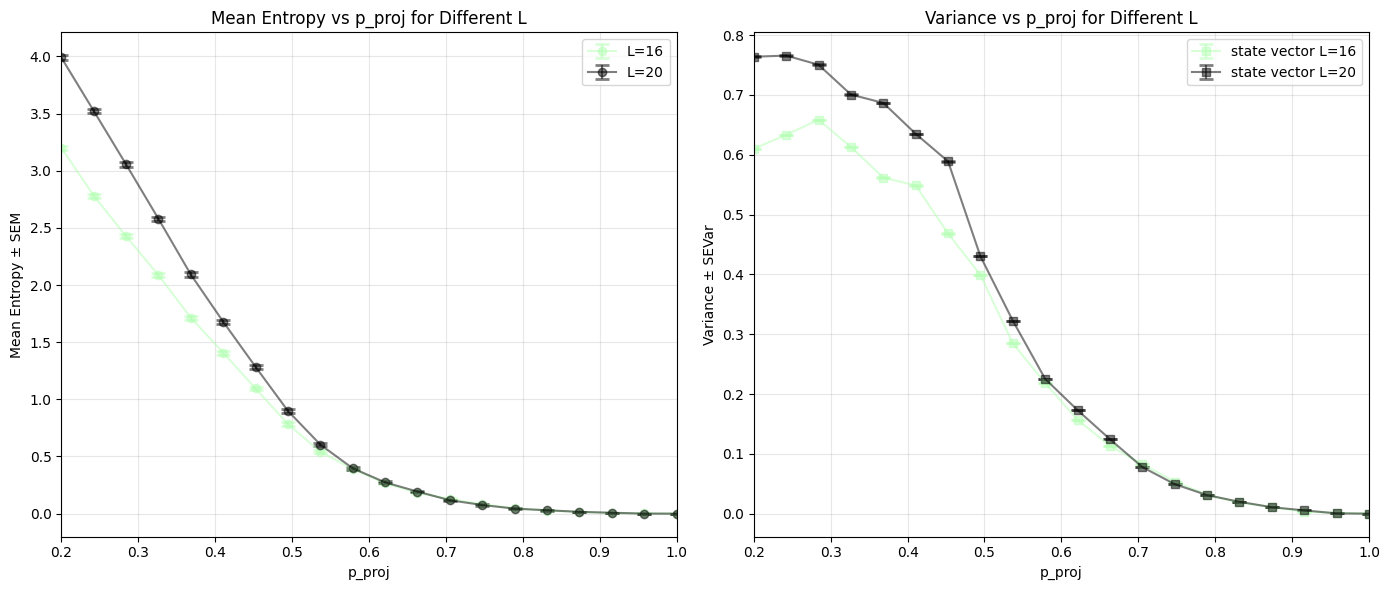

In [9]:
import glob
import os
from functools import partial
from read_hdf5_func import calculate_mean_and_error, calculate_variance_and_error

SvN_fixed = partial(von_neumann_entropy_sv, n=0, positivedefinite=False, threshold=1e-15)

# Pattern to match folders
pattern_sv = "/scratch/ty296/sv_L*_p_ctrl0.000_p0.200-1.000/final_results_L*.h5"
folders_sv = glob.glob(pattern_sv)[1:]
# print(folders[1:])

# extract L values from folder names
from pathlib import Path
import re
L_values_sv = [int(re.search(r'L(\d+)', folder).group(1)) for folder in folders_sv]
print(L_values_sv)

# Create increasingly deeper shades of blue proportional to L value
# Smaller L = very light blue, larger L = darker blue
colors_sv = []
min_L = min(L_values_sv)
max_L = max(L_values_sv)

for L in L_values_sv:
    # Normalize L to range [0, 1]
    norm_L = (L - min_L) / (max_L - min_L)
    
    # Create light green to dark green gradient
    # Light green: (0.7, 1.0, 0.7), Dark green: (0.0, 0.8, 0.0)
    red = 0.7 * (1 - norm_L)      # From 0.7 to 0.0
    green = 1.0 * (1 - norm_L)    # From 1.0 to 0.0  
    blue = 0.7 * (1 - norm_L)     # From 0.7 to 0.0
    
    green_color = (red, green, blue)
    
    colors_sv.append(green_color)

# Organize data by L values
plot_data_sv = {}
for L in L_values_sv:
    plot_data_sv[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}

for filename, L in zip(folders_sv, L_values_sv):
    h5_file = h5py.File(filename, 'r')
    data_set = h5_file['p_ctrl0.000']['singular_values']['AB']
    p_proj_values = h5_file['p_ctrl0.000']['p_proj']

    raw_s0_data = np.apply_along_axis(SvN_fixed, axis=2, arr=data_set)
    s0_mean_data = np.apply_along_axis(calculate_mean_and_error, axis=1, arr=raw_s0_data)
    s0_var_data = np.apply_along_axis(calculate_variance_and_error, axis=1, arr=raw_s0_data)
    plot_data_sv[L]['p_proj'] = p_proj_values[:]
    plot_data_sv[L]['mean'] = s0_mean_data[:,0]
    plot_data_sv[L]['sem'] = s0_mean_data[:,1]
    plot_data_sv[L]['variance'] = s0_var_data[:,0]
    plot_data_sv[L]['se_var'] = s0_var_data[:,1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: p_proj vs mean ± sem
for i, L in enumerate(L_values_sv):
    ax1.errorbar(plot_data_sv[L]['p_proj'], plot_data_sv[L]['mean'], yerr=plot_data_sv[L]['sem'], 
                label=f'L={L}', marker='o', capsize=5, capthick=2, color=colors_sv[i], alpha=0.5)

ax1.set_xlabel('p_proj')
ax1.set_ylabel('Mean Entropy ± SEM')
ax1.set_title('Mean Entropy vs p_proj for Different L')
ax1.legend()
ax1.set_xlim(0.2, 1.0)
ax1.grid(True, alpha=0.3)

# Plot 2: p_proj vs variance ± se_var
for i, L in enumerate(L_values_sv):
    data = plot_data_sv[L]
    
    ax2.errorbar(data['p_proj'], data['variance'], yerr=data['se_var'], 
                label=f'state vector L={L}', marker='s', capsize=5, capthick=2, color=colors_sv[i], alpha=0.5)

ax2.set_xlabel('p_proj')
ax2.set_ylabel('Variance ± SEVar')
ax2.set_title('Variance vs p_proj for Different L')
ax2.legend()
ax2.set_xlim(0.2, 1.0)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig(f'{self.save_folder}/s{self.n}_threshold{threshold:.1e}_{self.p_fixed_name}{self.p_fixed_value}.png')
# print(f'threshold {threshold} saved to {self.save_folder}/s{self.n}_threshold{threshold:.1e}_{self.p_fixed_name}{self.p_fixed_value}.png')
plt.show()

threshold 1e-15 saved to /scratch/ty296/plots/s0_threshold1.0e-15_p_ctrl0.0.png


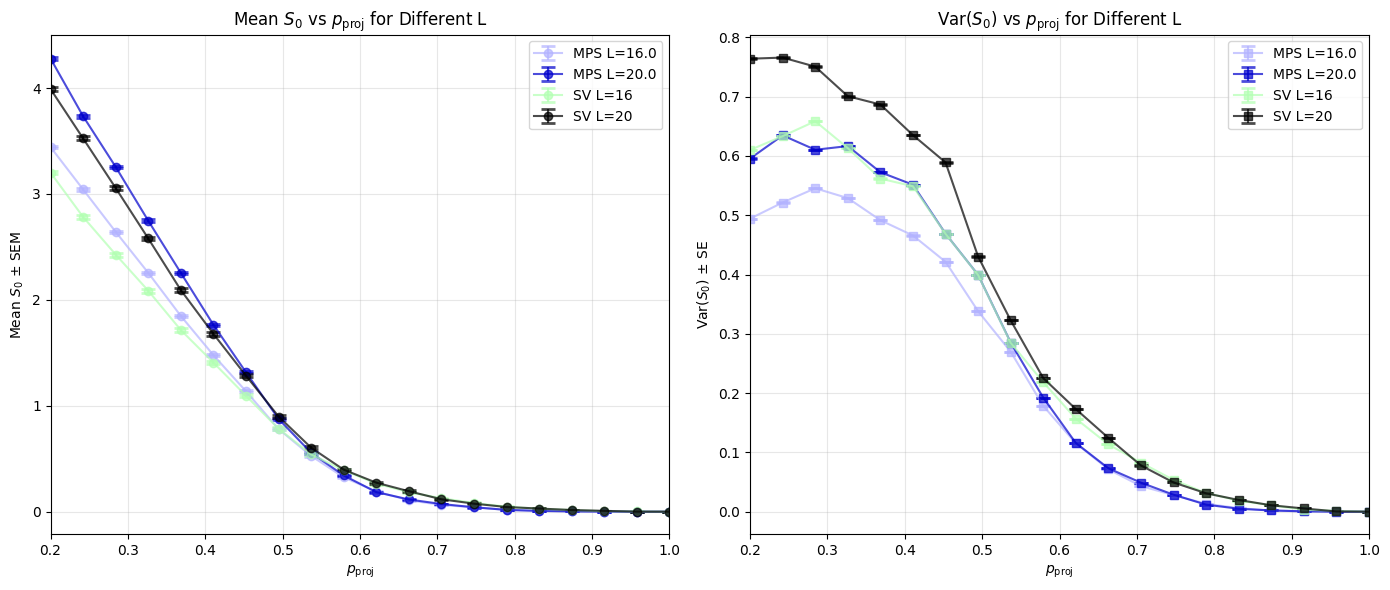

In [11]:
import pandas as pd

p_fixed_name = "p_ctrl"
p_fixed_value = 0.0
n = 0
alpha_sv = 0.7
alpha_mps = 0.7
pwd = "/scratch/ty296/"
threshold = 1e-15
sv_combined = os.path.join(pwd, "hdf5_data_combined/sv_combined_{}{}.h5".format(p_fixed_name, p_fixed_value))
dir_name = os.path.join(pwd, "hdf5_data/{}{}".format(p_fixed_name, p_fixed_value))
save_folder = os.path.join(pwd, "plots")

csv_path = os.path.join(save_folder, f's{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.csv')
df = pd.read_csv(csv_path)

# Organize MPS data by L values (separate from state vector data)
plot_data_mps = {}
for _, row in df.iterrows():
    L = row['L']
    if L not in plot_data_mps:
        plot_data_mps[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
    
    plot_data_mps[L]['p_proj'].append(row['p_proj'])
    plot_data_mps[L]['mean'].append(row['mean'])
    plot_data_mps[L]['sem'].append(row['sem'])
    plot_data_mps[L]['variance'].append(row['variance'])
    plot_data_mps[L]['se_var'].append(row['se_var'])

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get sorted L values for MPS data and create color map
L_values = sorted(plot_data_mps.keys())[1:3]
n_L = len(L_values)

# Create increasingly deeper shades of blue proportional to L value for MPS data
# Smaller L = very light blue, larger L = darker blue
colors = []
if len(L_values) > 1:
    min_L = min(L_values)
    max_L = max(L_values)
    for L in L_values:
        # Normalize L to range [0, 1]
        norm_L = (L - min_L) / (max_L - min_L)
        
        # Create light blue to dark blue gradient
        # Light blue: (0.7, 0.7, 1.0), Dark blue: (0.0, 0.0, 0.8)
        red = 0.7 * (1 - norm_L)      # From 0.7 to 0.0
        green = 0.7 * (1 - norm_L)    # From 0.7 to 0.0  
        blue = 1.0 - 0.2 * norm_L     # From 1.0 to 0.8
        
        blue_color = (red, green, blue)
        colors.append(blue_color)
else:
    colors = [(0.0, 0.0, 0.8)]  # Single dark blue color

# Plot 1: MPS data - p_proj vs mean ± sem
for i, L in enumerate(L_values):
    data = plot_data_mps[L]
    # Sort by p_proj for cleaner lines
    sorted_indices = np.argsort(data['p_proj'])
    p_proj_sorted = np.array(data['p_proj'])[sorted_indices]
    mean_sorted = np.array(data['mean'])[sorted_indices]
    sem_sorted = np.array(data['sem'])[sorted_indices]
    
    ax1.errorbar(p_proj_sorted, mean_sorted, yerr=sem_sorted, 
                label=f'MPS L={L}', marker='o', capsize=5, capthick=2, color=colors[i], alpha=alpha_mps)

# Plot 1: State vector data overlay - p_proj vs mean ± sem
for i, L in enumerate(L_values_sv):
    ax1.errorbar(plot_data_sv[L]['p_proj'], plot_data_sv[L]['mean'], yerr=plot_data_sv[L]['sem'], 
                label=f'SV L={L}', marker='o', capsize=5, capthick=2, color=colors_sv[i], alpha=alpha_sv)

ax1.set_xlabel(r'$p_{\mathrm{proj}}$')
ax1.set_ylabel(r'Mean $S_0$ ± SEM')
ax1.set_title(r'Mean $S_0$ vs $p_{\mathrm{proj}}$ for Different L')
ax1.legend()
ax1.set_xlim(0.2, 1.0)
ax1.grid(True, alpha=0.3)

# Plot 2: MPS data - p_proj vs variance ± se_var
for i, L in enumerate(L_values):
    data = plot_data_mps[L]
    # Sort by p_proj for cleaner lines
    sorted_indices = np.argsort(data['p_proj'])
    p_proj_sorted = np.array(data['p_proj'])[sorted_indices]
    variance_sorted = np.array(data['variance'])[sorted_indices]
    se_var_sorted = np.array(data['se_var'])[sorted_indices]
    
    ax2.errorbar(p_proj_sorted, variance_sorted, yerr=se_var_sorted, 
                label=f'MPS L={L}', marker='s', capsize=5, capthick=2, color=colors[i], alpha=alpha_mps)

# Plot 2: State vector data overlay - p_proj vs variance ± se_var
for i, L in enumerate(L_values_sv):
    data = plot_data_sv[L]
    
    ax2.errorbar(data['p_proj'], data['variance'], yerr=data['se_var'], 
                label=f'SV L={L}', marker='s', capsize=5, capthick=2, color=colors_sv[i], alpha=alpha_sv)

ax2.set_xlabel(r'$p_{\mathrm{proj}}$')
ax2.set_ylabel(r'Var($S_0$) ± SE')
ax2.set_title(r'Var($S_0$) vs $p_{\mathrm{proj}}$ for Different L')
ax2.legend()
ax2.set_xlim(0.2, 1.0)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig(f'{save_folder}/s{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.png')
# plt.close()
print(f'threshold {threshold} saved to {save_folder}/s{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.png')
plt.show()